In [1]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob

from transformers import get_constant_schedule_with_warmup
from sklearn.metrics import precision_score,recall_score,accuracy_score

from src.train import trainModel
from src.dataloader import getData,spliceDataset,h5pyDataset,collate_fn
from src.weight_init import keras_init
from src.losses import categorical_crossentropy_2d
from src.models import SpliceFormer
from src.evaluation_metrics import print_topl_statistics
#import tensorflow as tf

In [2]:
#!pip install pickle5

In [3]:
!nvidia-smi

Thu Jun  2 16:36:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   36C    P0    57W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

In [4]:
rng = np.random.default_rng(23673)

In [5]:
data_dir = '../Data'

In [6]:
#gtf = None

In [7]:
L = 32
N_GPUS = 8
k = 2
# Hyper-parameters:
# L: Number of convolution kernels
# W: Convolution window size in each residual unit
# AR: Atrous rate in each residual unit

W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])
BATCH_SIZE = k*6*N_GPUS


CL = 2 * np.sum(AR*(W-1))

In [8]:
SL=5000
CL_max=40000

In [9]:
setType = 'test'
annotation_test, transcriptToLabel_test, seqData = getData(data_dir, setType)    

In [10]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

temp = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = SpliceFormer(CL_max)
model_m.apply(keras_init)
model_m = model_m.to(device)

if torch.cuda.device_count() > 1:
    model_m = nn.DataParallel(model_m)

output_class_labels = ['Null', 'Acceptor', 'Donor']

#for output_class in [1,2]:
#models = [copy.deepcopy(model_m) for i in range(n_models)]
#[model.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_2_{}'.format(i))) for i,model in enumerate(models)]
#chunkSize = num_idx/10

model_m.load_state_dict(torch.load('../Results/PyTorch_Models/transformer_encoder_40k_270522_3'))



#model_m.transformerBlock1.transformer.layers[0][0].fn.attend.register_forward_hook(get_activation('attend'))



<All keys matched successfully>

In [11]:
BATCH_SIZE=1

In [12]:
model_m.module.transformerBlocks[0].transformer.layers[0][0].fn.attend.register_forward_hook(get_activation('attend1'))
model_m.module.transformerBlocks[0].transformer.layers[1][0].fn.attend.register_forward_hook(get_activation('attend2'))
model_m.module.transformerBlocks[0].transformer.layers[2][0].fn.attend.register_forward_hook(get_activation('attend3'))
model_m.module.transformerBlocks[0].transformer.layers[3][0].fn.attend.register_forward_hook(get_activation('attend4'))
#model_m.module.SpliceAI.skip_layers[0].register_forward_hook(get_activation('attention_selector1'))
#model_m.module.SpliceAI.skip_layers[1].register_forward_hook(get_activation('attention_selector2'))
#model_m.module.SpliceAI.skip_layers[2].register_forward_hook(get_activation('attention_selector3'))
#model_m.module.SpliceAI.skip_layers[3].register_forward_hook(get_activation('attention_selector4'))
#model_m.module.SpliceAI.skip_layers[4].register_forward_hook(get_activation('attention_selector5'))

In [13]:
def plotAttentionWeights(model_m,batch_features,targets,shift,name):
    output = model_m(batch_features)
    tmp = nn.Softmax(dim=1)(model_m.module.conv_final(model_m.module.SpliceAI(batch_features)[1]))
    acceptors_sorted = torch.argsort(tmp[:,1,:],dim=1,descending=True)[:,:512//2:]
    donors_sorted = torch.argsort(tmp[:,2,:],dim=1,descending=True)[:,:512//2]
    splice_idx = torch.cat([acceptors_sorted,donors_sorted],dim=1)
    splice_idx = torch.sort(splice_idx,dim=1).values.cpu().numpy()

    donor_idxs = torch.argsort(targets[2,:],descending=True)[:int(torch.sum(targets[1,:]))].cpu().numpy()+20000-shift
    donor_idxs_2 = donor_idxs[np.where(np.logical_and(donor_idxs>=20000, donor_idxs<=25000))]
    acceptor_idxs = torch.argsort(targets[1,:],descending=True)[:int(torch.sum(targets[1,:]))].cpu().numpy()+20000-shift
    acceptor_idxs_2 = acceptor_idxs[np.where(np.logical_and(acceptor_idxs>=20000, acceptor_idxs<=25000))]
    incl_idxs = []
    for donor_idx in donor_idxs_2:
        tmp = np.arange(512)[splice_idx[0,:] == donor_idx]
        if len(tmp)>0:
            incl_idxs.append(tmp[0])

    for acceptor_idx in acceptor_idxs_2:
        tmp = np.arange(512)[splice_idx[0,:] == acceptor_idx]
        if len(tmp)>0:
            incl_idxs.append(tmp[0])
    
    attention = np.concatenate([activation['attend{}'.format(i+1)][0,:,:,:].cpu().numpy() for i in range(4)],axis=0)
    
    for i,val in enumerate(incl_idxs):
        attentionExpanded = np.zeros(45000)
        #print(val,splice_idx[0,val])
        attentionExpanded[splice_idx] = np.mean(attention[:,val,:],axis=0)

        start,end = 0,45000
        start_shift = 20000
        fig = plt.figure()
        plt.plot(range(start+shift-start_shift,end+shift-start_shift),attentionExpanded[start:end])
        a = acceptor_idxs[np.where(np.logical_and(acceptor_idxs>=start, acceptor_idxs<=end))]
        plt.scatter(np.arange(start+shift-start_shift,end+shift-start_shift)[a],attentionExpanded[a]+0.001,c='red',marker="^", clip_on=False, zorder=10,label='Acceptor')
        d = donor_idxs[np.where(np.logical_and(donor_idxs>=start, donor_idxs<=end))]
        plt.scatter(np.arange(start+shift-start_shift,end+shift-start_shift)[d],attentionExpanded[d]+0.001,c='green',marker="^", clip_on=False, zorder=10,label='Donor')
        plt.scatter([splice_idx[0,val]+shift-start_shift],attentionExpanded[splice_idx[0,val]]+0.003,c='black',marker="v", clip_on=False, zorder=10,label='Selected')
        plt.legend()
        plt.xlabel('Directed distance from transcript start (nt)')
        plt.ylabel('Attention')
        plt.savefig('../Results/AttentionPlots/{}_{}.png'.format(name,i), dpi=400)
        plt.show()
        plt.close()

In [14]:
specific_anno = annotation_test[annotation_test['name'].apply(lambda x: x.split('--')[0])=='CFTR']

In [15]:
test_dataset = spliceDataset(specific_anno,transcriptToLabel_test,SL,CL_max)
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0,collate_fn=collate_fn, pin_memory=True)
outputs = []
targets = []
for i,(batch_chunks,target_chunks) in enumerate(tqdm(test_loader)):
    #print()
    batch_chunks = torch.transpose(batch_chunks.to(device),1,2)
    target_chunks = torch.transpose(target_chunks.to(device),1,2)
    batch_chunks = torch.split(batch_chunks, BATCH_SIZE, dim=0)
    target_chunks = torch.split(target_chunks, BATCH_SIZE, dim=0)
    #targets = torch.squeeze(torch.cat(target_chunks,dim=2),dim=0)
    targets = target_chunks
    for j in range(len(batch_chunks)):
        batch_features = batch_chunks[j]
        #targets = target_chunks[j]
        #targets.append(batch_features)
        outputs.append(model_m(batch_features)[1])
        

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.93s/it]


In [16]:
outputs = torch.cat(outputs,dim=2)
targets = torch.cat(targets,dim=2)

In [17]:
outputs = outputs.cpu().detach().numpy()
targets = targets.cpu().detach().numpy()

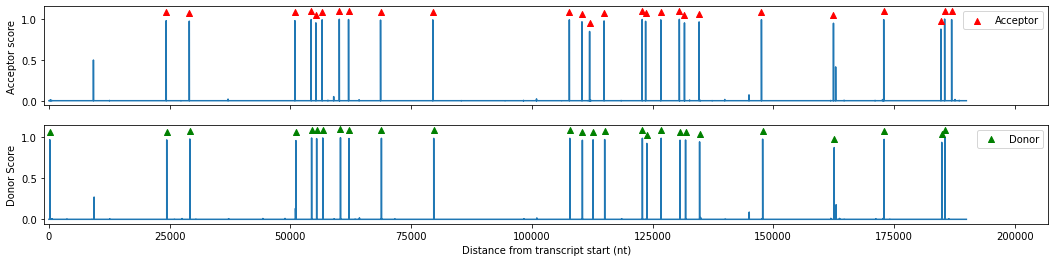

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(18, 4),sharex=True)
ax1.plot(outputs[0,1,:])
ax2.plot(outputs[0,2,:])
cond = targets[0,1,:]==1
ax1.scatter(np.arange(outputs.shape[2])[cond],outputs[0,1,:][cond]+0.1,c='red',marker="^", clip_on=False, zorder=10,label='Acceptor')
cond = targets[0,2,:]==1
ax2.scatter(np.arange(outputs.shape[2])[cond],outputs[0,2,:][cond]+0.1,c='green',marker="^", clip_on=False, zorder=10,label='Donor')
plt.xlabel('Distance from transcript start (nt)')
ax1.set_ylabel('Acceptor score')
ax1.set_xlim([-1000,207000])
ax2.set_ylabel('Donor Score')
ax1.legend()
ax2.legend()
plt.savefig('../Results/Transformer_CFTR_scores.png', dpi=400)
plt.show()

  0%|                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s]

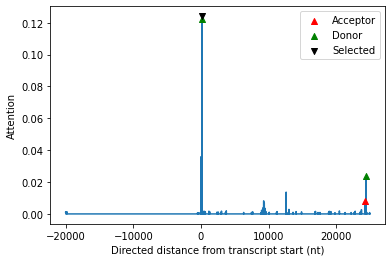

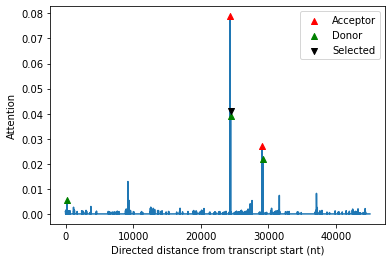

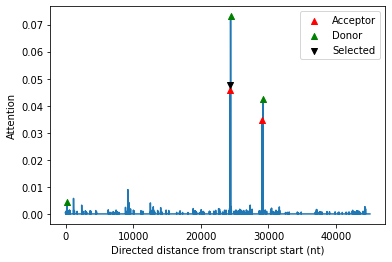

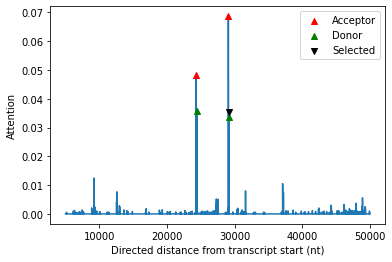

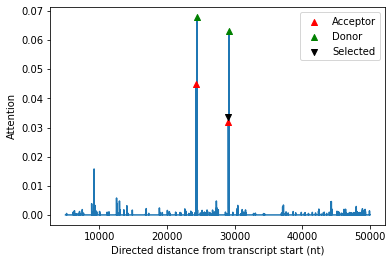

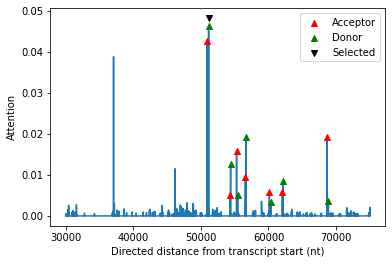

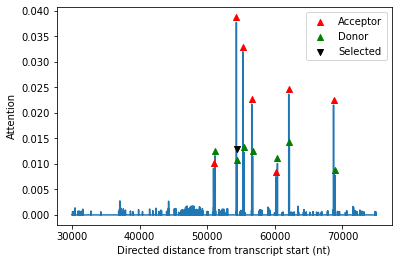

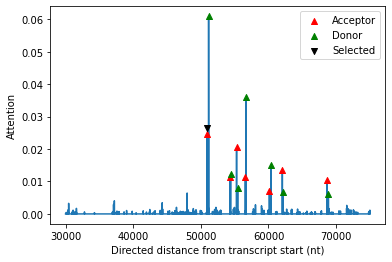

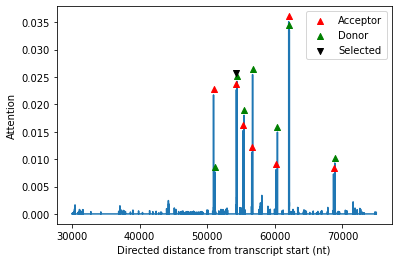

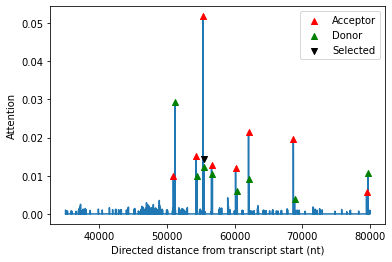

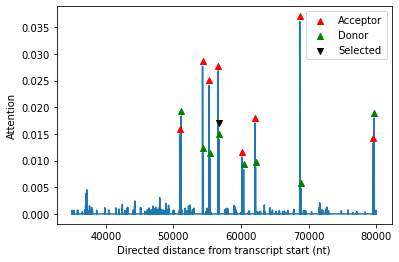

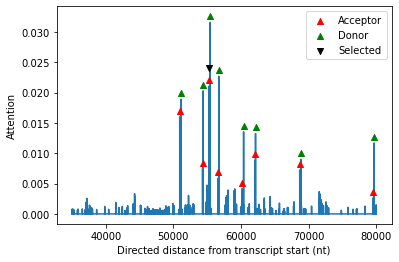

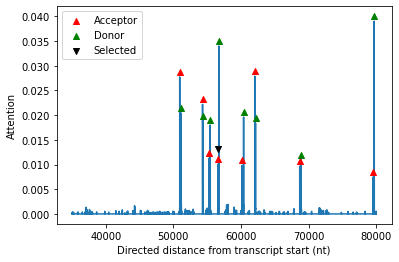

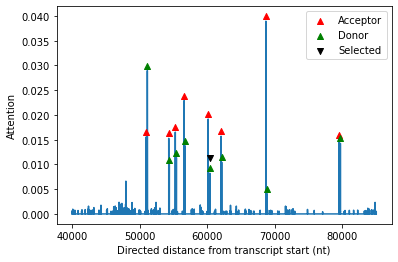

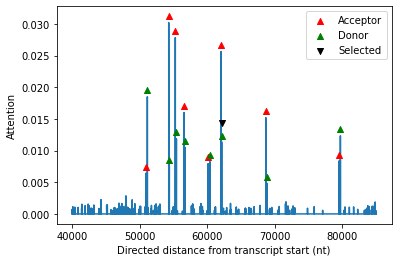

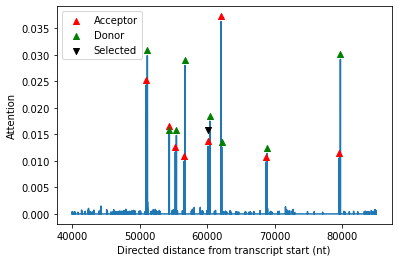

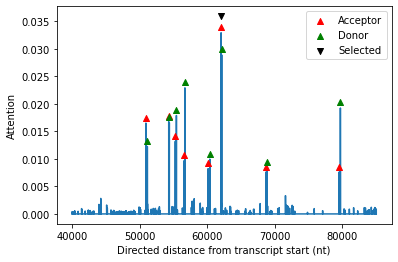

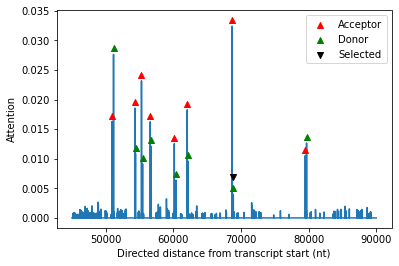

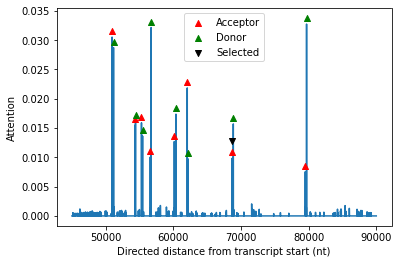

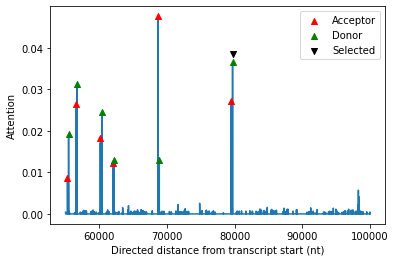

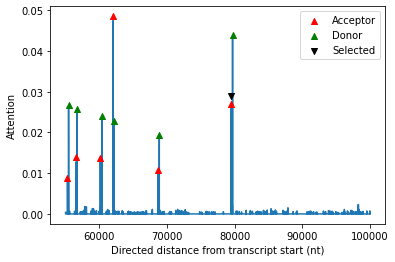

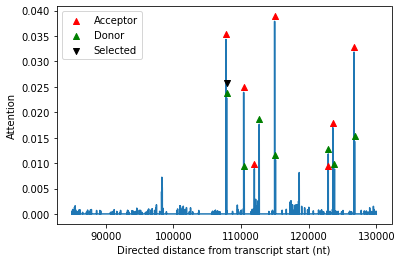

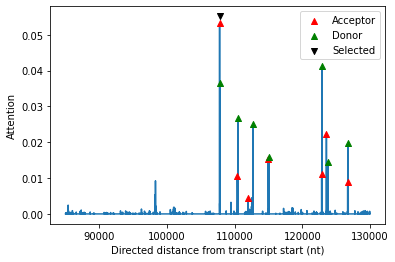

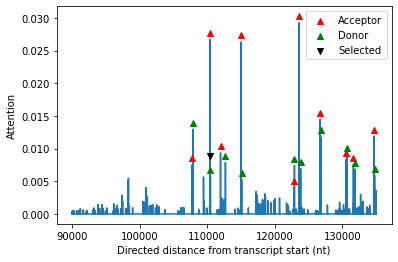

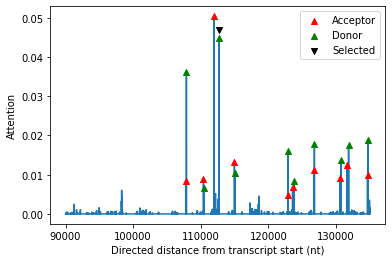

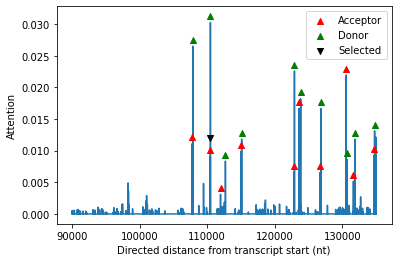

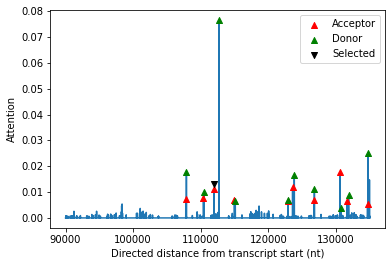

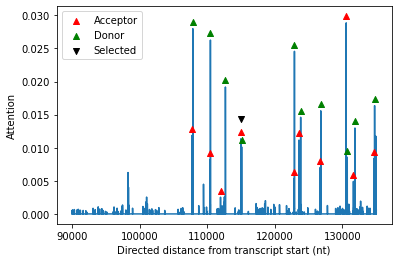

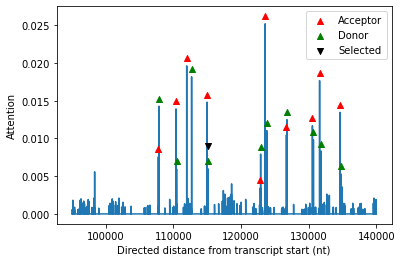

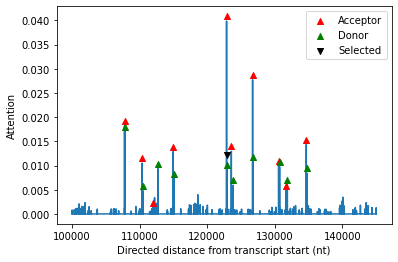

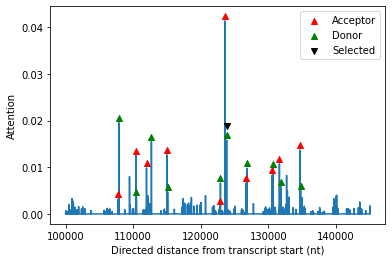

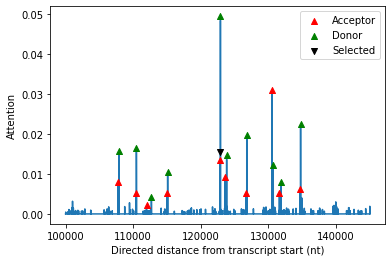

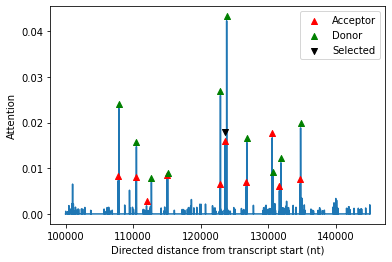

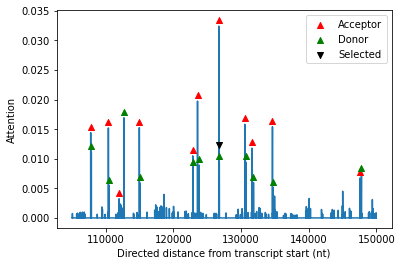

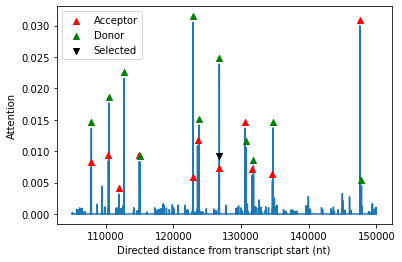

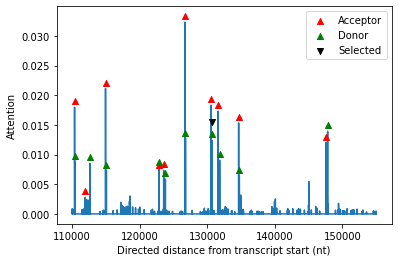

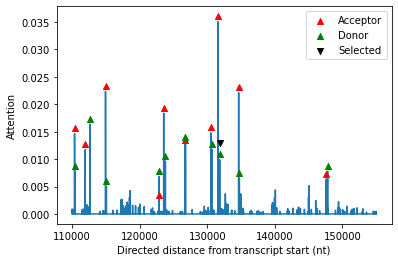

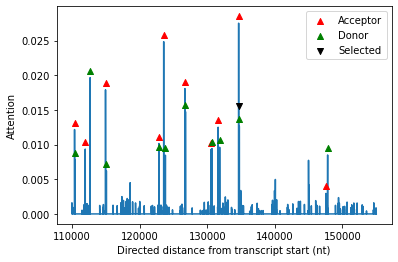

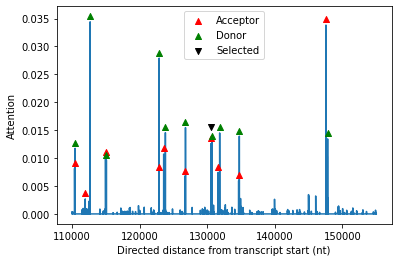

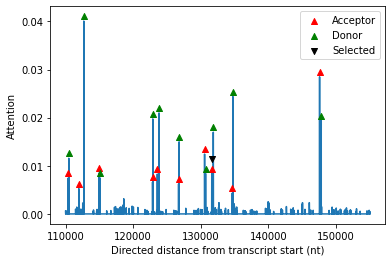

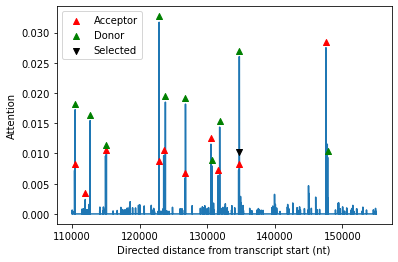

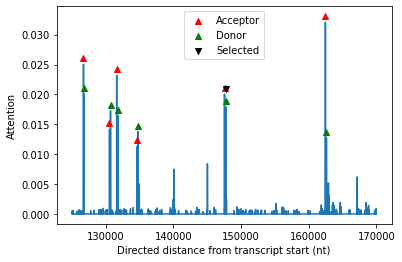

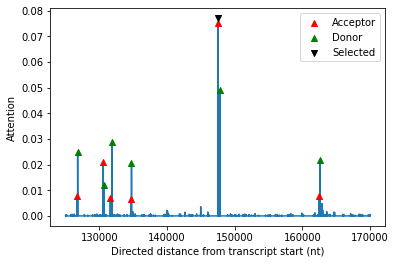

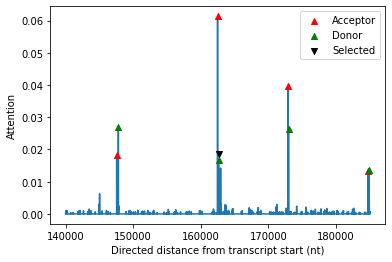

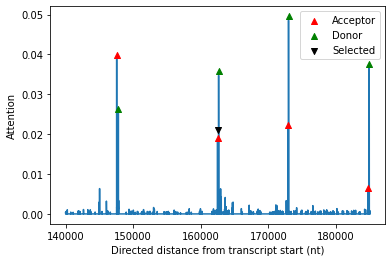

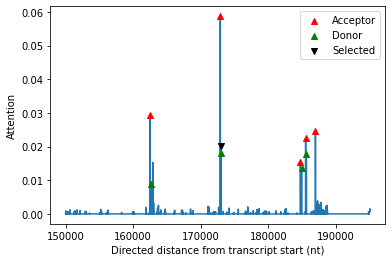

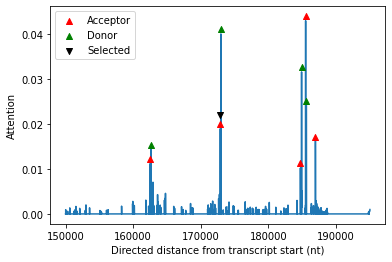

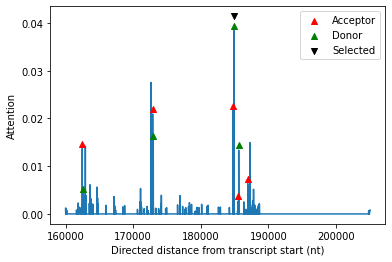

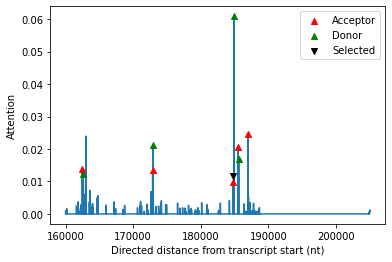

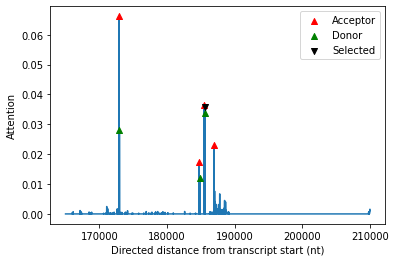

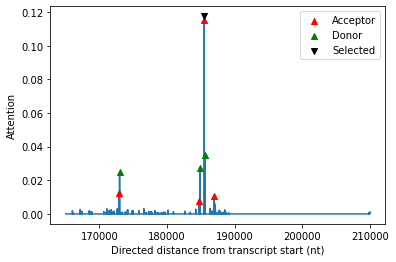

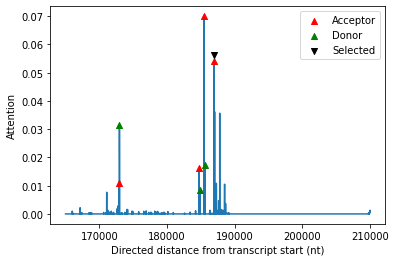

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.81s/it]


In [19]:
test_dataset = spliceDataset(specific_anno,transcriptToLabel_test,SL,CL_max)
test_dataset.seqData = seqData
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0,collate_fn=collate_fn, pin_memory=True)

for i,(batch_chunks,target_chunks) in enumerate(tqdm(test_loader)):
    #print()
    batch_chunks = torch.transpose(batch_chunks.to(device),1,2)
    target_chunks = torch.transpose(target_chunks.to(device),1,2)
    batch_chunks = torch.split(batch_chunks, BATCH_SIZE, dim=0)
    target_chunks = torch.split(target_chunks, BATCH_SIZE, dim=0)
    targets = torch.squeeze(torch.cat(target_chunks,dim=2),dim=0)
    #targets_list = []
    #outputs_list = []
    for j in range(len(batch_chunks)):
        batch_features = batch_chunks[j]
        #targets = target_chunks[j]
        plotAttentionWeights(model_m,batch_features,targets,j*5000,'CFTR_{}'.format(j+1))

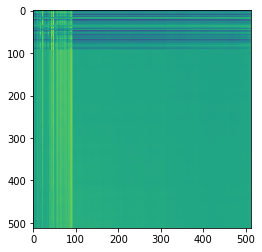

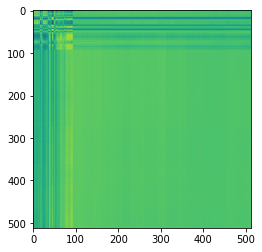

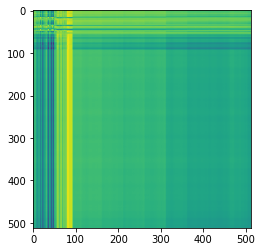

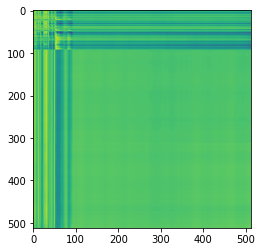

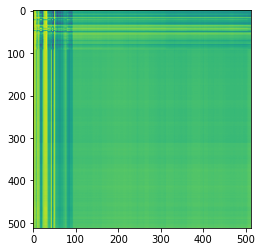

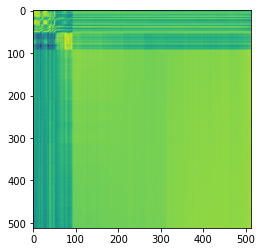

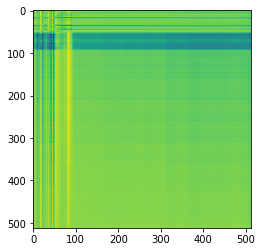

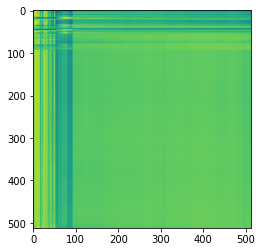

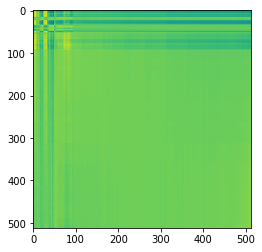

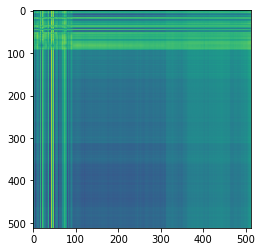

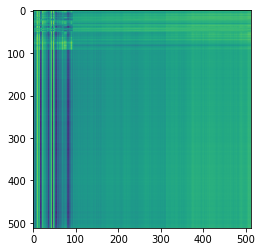

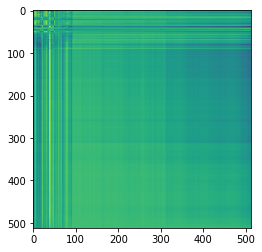

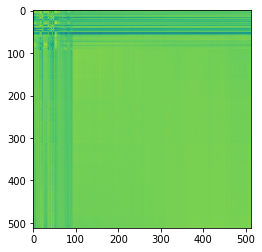

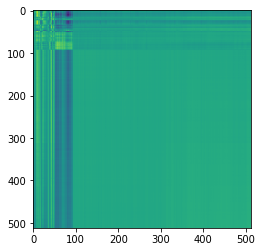

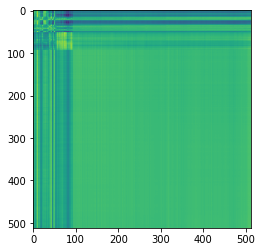

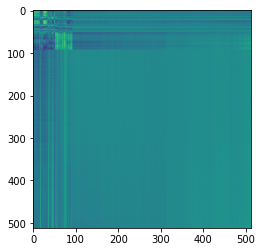

In [20]:
for i in range(4):
    plt.imshow(np.log(activation['attend1'][0,i,:,:].cpu().numpy()))
    plt.show()
    
for i in range(4):
    plt.imshow(np.log(activation['attend2'][0,i,:,:].cpu().numpy()))
    plt.show()

for i in range(4):
    plt.imshow(np.log(activation['attend3'][0,i,:,:].cpu().numpy()))
    plt.show()

for i in range(4):
    plt.imshow(np.log(activation['attend4'][0,i,:,:].cpu().numpy()))
    plt.show()

In [20]:
#plt.imshow(np.log(np.mean(attention,axis=0)))
#plt.colorbar()
#plt.show()